Here is the forward prediction model for molecular graphs. As a results various graph models will be introduced. The first one to be introduced is the chemprop implementation which is abased on the Directed MPNN proposed by Kevin Yang et al. 

From the paper it states the detail the original Message passing neural network(MPNN) and their Directed MPNN:

An MPNN is a model which operates on an undirected graph G with node (atom) features xv and edge (bond) features evw. MPNNs operate in two phases: a message passing phase, which transmits information across the molecule to build a neural representation of the molecule, and a readout phase, which uses the final representation of the molecule to make predictions about the properties of interest.
More specifically, the message passing phase consists of T steps. On each step t, hidden states hvt and messages mvt associated with each vertex v are updated using message function Mt and vertex update function Ut according to

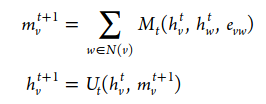

where N(v) is the set of neighbors of v in graph G, and hv0 is some function of the initial atom features xv. The readout phase then uses a readout function R to make a property prediction based on the final hidden states according to

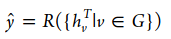

The main difference between the Directed MPNN (D-MPNN) and the generic MPNN described above is the nature of the messages sent during the message passing phase. Rather than using messages associated with vertices (atoms), D-MPNN uses messages associated with directed edges (bonds). The motivation of this design is to prevent totters,  that is, to avoid messages being passed along any path of the form v1v2···vn where vi = vi+2 for some i. Such excursions are likely to introduce noise into the graph representation. Using Figure 1 as an illustration, in D-MPNN, the message 1 → 2 will only be propagated to nodes 3 and 4 in the next iteration, whereas in the original MPNN it will be sent to node 1 as well, creating an unnecessary loop in the message passing trajectory.

However from the definition - Tottering is the phenomenon that a walk of infinite length may go back and forth along the same edge, thereby creating an artificially inflated similarity score if two graphs share a common edge. So it is more related to random walk. I am not very sure whether the original MPNN will have this problem or not. In terms of molecules field, and if random walk is not introduced during the message passing, tottering should not exist. 
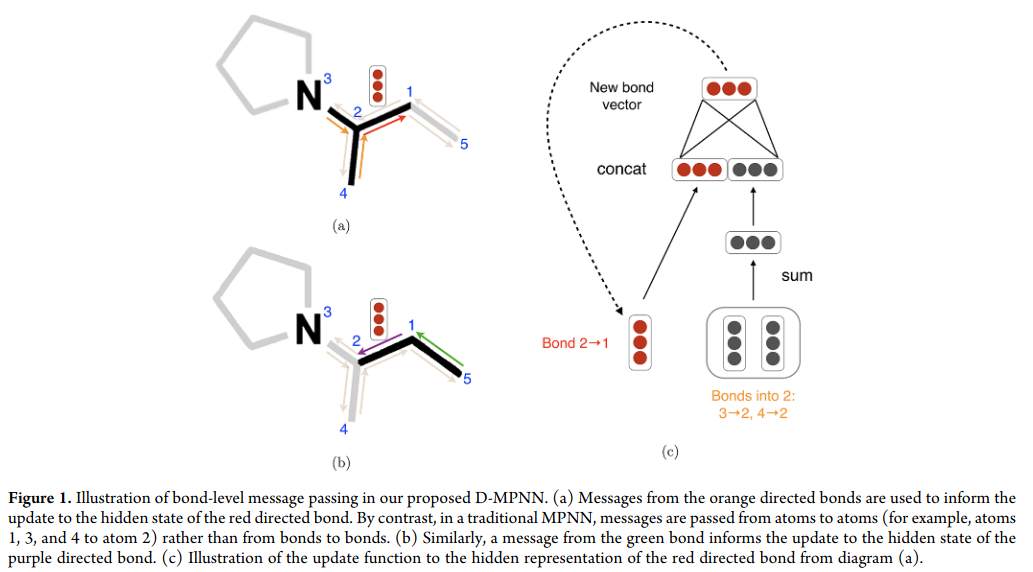


In [2]:
# !pip install typed-argument-parser
# !pip install tqdm

In [5]:
from typing import List, Union, Tuple
from functools import reduce
import numpy as np
from rdkit import Chem
import torch
import torch.nn as nn
from Chemprop_args import TrainArgs
from Chemprop_features import BatchMolGraph, get_atom_fdim, get_bond_fdim, mol2graph
from nn_utility_for_chemprop import index_select_ND, get_activation_function

In [6]:

class MPNEncoder(nn.Module):
    """An :class:`MPNEncoder` is a message passing neural network for encoding a molecule."""

    def __init__(self, args: TrainArgs, atom_fdim: int, bond_fdim: int, hidden_size: int = None,
                 bias: bool = None, depth: int = None):
        """
        :param args: A :class:`~chemprop.args.TrainArgs` object containing model arguments.
        :param atom_fdim: Atom feature vector dimension.
        :param bond_fdim: Bond feature vector dimension.
        :param hidden_size: Hidden layers dimension
        :param bias: Whether to add bias to linear layers
        :param depth: Number of message passing steps

        For this model, actually I think it is a recurrent based graph neural network
        as across different layers, it shared weights.
       """
        super(MPNEncoder, self).__init__()
        self.atom_fdim = atom_fdim
        self.bond_fdim = bond_fdim
        self.atom_messages = args.atom_messages
        self.hidden_size = hidden_size or args.hidden_size # This is tuable
        self.bias = bias or args.bias
        self.depth = depth or args.depth # This controlled by number of information change steps
        self.dropout = args.dropout
        self.layers_per_message = 1
        self.undirected = args.undirected  # if undirected then it is the original MPNN, not the Directed MPNN
        self.device = args.device
        self.aggregation = args.aggregation
        self.aggregation_norm = args.aggregation_norm

        # Dropout
        self.dropout_layer = nn.Dropout(p=self.dropout)

        # Activation
        self.act_func = get_activation_function(args.activation)

        # Cached zeros
        self.cached_zero_vector = nn.Parameter(torch.zeros(self.hidden_size), requires_grad=False)

        # Input
        input_dim = self.atom_fdim if self.atom_messages else self.bond_fdim # Here one can choose the message is on atoms or bonds
        # From the original paper it is on bonds
        self.W_i = nn.Linear(input_dim, self.hidden_size, bias=self.bias)
        '''
        Weights W_i is used to initialize edge hidden states, in the paper the bond features are created by
        concate the bond features with atoms features it will concate the features of bond v to w with atom v. 
        The detail of feature construction is discussed in the featurization part. The input is in the shape
        (num of bonds in the batch graph, the size of bond feature+atom feature). After the W_i, it will become
        (num of bonds in batch graph, hidden size). (n x bond_fdim) x (bond_fdim x hidden_size) = N X hidden_size
        '''
        if self.atom_messages:
            w_h_input_size = self.hidden_size + self.bond_fdim
        else:
            w_h_input_size = self.hidden_size

        # Shared weight matrix across depths (default)
        self.W_h = nn.Linear(w_h_input_size, self.hidden_size, bias=self.bias)
        '''
        This will times with the information to update the message
        '''

        self.W_o = nn.Linear(self.atom_fdim + self.hidden_size, self.hidden_size)
        '''
        This one only for the final readout part. The atom raw feature will concate with the 
        updated hidden information. so the shape is (self.atom_fdim + self.hidden_size, self.hidden_size)
        
        '''

        # layer after concatenating the descriptors if args.atom_descriptors == descriptors
        if args.atom_descriptors == 'descriptor':
            self.atom_descriptors_size = args.atom_descriptors_size
            self.atom_descriptors_layer = nn.Linear(self.hidden_size + self.atom_descriptors_size,
                                                    self.hidden_size + self.atom_descriptors_size,)

    def forward(self,
                mol_graph: BatchMolGraph,
                atom_descriptors_batch: List[np.ndarray] = None) -> torch.FloatTensor:
        """
        Encodes a batch of molecular graphs.
        :param mol_graph: A :class:`~chemprop.features.featurization.BatchMolGraph` representing
                          a batch of molecular graphs.
        :param atom_descriptors_batch: A list of numpy arrays containing additional atomic descriptors
        :return: A PyTorch tensor of shape :code:`(num_molecules, hidden_size)` containing the encoding of each molecule.
        """
        if atom_descriptors_batch is not None:
            atom_descriptors_batch = [np.zeros([1, atom_descriptors_batch[0].shape[1]])] + atom_descriptors_batch   # padding the first with 0 to match the atom_hiddens
            atom_descriptors_batch = torch.from_numpy(np.concatenate(atom_descriptors_batch, axis=0)).float().to(self.device)

        f_atoms, f_bonds, a2b, b2a, b2revb, a_scope, b_scope = mol_graph.get_components(atom_messages=self.atom_messages)
        f_atoms, f_bonds, a2b, b2a, b2revb = f_atoms.to(self.device), f_bonds.to(self.device), a2b.to(self.device), b2a.to(self.device), b2revb.to(self.device)

        if self.atom_messages:
            a2a = mol_graph.get_a2a().to(self.device)

        # Input
        if self.atom_messages:
            input = self.W_i(f_atoms)  # num_atoms x hidden_size
        else:
            input = self.W_i(f_bonds)  # num_bonds x hidden_size
        message = self.act_func(input)  # num_bonds x hidden_size

        # Message passing
        for depth in range(self.depth - 1):
            if self.undirected:
                message = (message + message[b2revb]) / 2
                '''
                It will add in information of bond message and divide by 2. Means there is no difference between
                different directions of bond information.
                '''

            if self.atom_messages:
                '''
                It is like the original MPNN information is on atoms. Although it is only for incoming bond
                if directed. since it use the a2b. it will not consider the information flow that a bond information
                is only from bond going into it. And it will consider the atom and get information from its neighbor 
                atoms and the bond information into it. 
                '''
                nei_a_message = index_select_ND(message, a2a)  # num_atoms x max_num_bonds x hidden
                nei_f_bonds = index_select_ND(f_bonds, a2b)  # num_atoms x max_num_bonds x bond_fdim
                nei_message = torch.cat((nei_a_message, nei_f_bonds), dim=2)  # num_atoms x max_num_bonds x (hidden + bond_fdim)
                message = nei_message.sum(dim=1)  # num_atoms x (hidden + bond_fdim)
            else:
                # m(a1 -> a2) = [sum_{a0 \in nei(a1)} m(a0 -> a1)] - m(a2 -> a1)
                # message      a_message = sum(nei_a_message)      rev_message
                '''
                # m(a1 -> a2) = [sum_{a0 \in nei(a1)} m(a0 -> a1)] - m(a2 -> a1)
                # message      a_message = sum(nei_a_message)      rev_message
                It is according to the figure 1 in the original paper
                The matrix a2b records the bond to an atom. So according to the atom the information is incoming 
                from the bonds. nei_a_message used the index_select_ND function. The index_select_ND function used the 
                index_select function. It will out put a matrix with shape [num_atoms x max_num_bonds x hidden]
                which is like
                [[[1,2,3,4,5,5],[2,24,4,5,1,2]],
                 [[2,3,4,5,4,5], [hidden_sizze]],
                 [[],[] here is two if num_max_bond is two],
                 .....this dimension is num_atoms in the batch_graph]
                 
                 After the hidden_information for each atom's incoming bond is selected,
                 one can calculate the atom message representation inside the molecule, which is the sum of hidden information from incoming bonds
                 it use a_message = nei_a_message.sum(dim=1) since dim 1 is max_num_bonds. The padding of max_num_bonds
                 is done in batch graph class and the first row of f_bonds and f_atoms is zero padding thus when the 
                 index is to 0 then the feature vector is all zeros.
                 
                 rev_message = message[b2revb] b2revb is a list record the reverse bond of the bond.
                 it is like [2,1,4,3]
                 rev_message is change the position of bond features. now b1: a1 --> a2 is changed by b2: a2 --> a1
                 b2a record the bond is coming from which atom.
                 a_message is the atom message with shape num_atoms x hidden
                 the a_message of atom n has the information of all bond going into the atom
                 for a bond coming from atom n, it needs to has a_message - the rev_information of this bond
                 thus message = a_message[b2a] - message[b2revb]
                '''
                nei_a_message = index_select_ND(message, a2b)  # num_atoms x max_num_bonds x hidden
                a_message = nei_a_message.sum(dim=1)  # num_atoms x hidden
                rev_message = message[b2revb]  # num_bonds x hidden
                message = a_message[b2a] - rev_message  # num_bonds x hidden

            message = self.W_h(message)
            message = self.act_func(input + message)  # num_bonds x hidden_size
            '''
            it has a skip connection to add the original input, according to the shape it is the information
            pass to every bond.
            '''
            message = self.dropout_layer(message)  # num_bonds x hidden
        '''
        After the updating of message, the message will aggregate on the atoms 
        Then the atom_raw_features will concate with the atom_message
        Then there is a linear layer to output the atom hiddens.
        
        '''
        a2x = a2a if self.atom_messages else a2b
        nei_a_message = index_select_ND(message, a2x)  # num_atoms x max_num_bonds x hidden
        a_message = nei_a_message.sum(dim=1)  # num_atoms x hidden
        a_input = torch.cat([f_atoms, a_message], dim=1)  # num_atoms x (atom_fdim + hidden)
        atom_hiddens = self.act_func(self.W_o(a_input))  # num_atoms x hidden
        atom_hiddens = self.dropout_layer(atom_hiddens)  # num_atoms x hidden

        # concatenate the atom descriptors
        if atom_descriptors_batch is not None:
            if len(atom_hiddens) != len(atom_descriptors_batch):
                raise ValueError(f'The number of atoms is different from the length of the extra atom features')

            atom_hiddens = torch.cat([atom_hiddens, atom_descriptors_batch], dim=1)     # num_atoms x (hidden + descriptor size)
            atom_hiddens = self.atom_descriptors_layer(atom_hiddens)                    # num_atoms x (hidden + descriptor size)
            atom_hiddens = self.dropout_layer(atom_hiddens)                             # num_atoms x (hidden + descriptor size)

        # Readout
        mol_vecs = []
        for i, (a_start, a_size) in enumerate(a_scope):
            if a_size == 0:
                mol_vecs.append(self.cached_zero_vector)
            else:
                cur_hiddens = atom_hiddens.narrow(0, a_start, a_size)
                '''
                use narrow can get a narrow version of the tensor. 
                Returns a new tensor that is a narrowed version of input tensor. The dimension dim is input from start to start + length. 
                The returned tensor and input tensor share the same underlying storage.
                so can get the information for one molecule
                '''
                mol_vec = cur_hiddens  # (num_atoms for a molecule, hidden_size)
                if self.aggregation == 'mean':
                    mol_vec = mol_vec.sum(dim=0) / a_size
                elif self.aggregation == 'sum':
                    mol_vec = mol_vec.sum(dim=0)
                elif self.aggregation == 'norm':
                    mol_vec = mol_vec.sum(dim=0) / self.aggregation_norm
                mol_vecs.append(mol_vec)

        mol_vecs = torch.stack(mol_vecs, dim=0)  # (num_molecules, hidden_size)

        return mol_vecs  # num_molecules x hidden


class MPN(nn.Module):
    """An :class:`MPN` is a wrapper around :class:`MPNEncoder` which featurizes input as needed."""

    def __init__(self,
                 args: TrainArgs,
                 atom_fdim: int = None,
                 bond_fdim: int = None):
        """
        :param args: A :class:`~chemprop.args.TrainArgs` object containing model arguments.
        :param atom_fdim: Atom feature vector dimension.
        :param bond_fdim: Bond feature vector dimension.
        """
        super(MPN, self).__init__()
        self.reaction = args.reaction
        self.reaction_solvent = args.reaction_solvent
        self.atom_fdim = atom_fdim or get_atom_fdim(overwrite_default_atom=args.overwrite_default_atom_features,
                                                     is_reaction=(self.reaction or self.reaction_solvent))
        self.bond_fdim = bond_fdim or get_bond_fdim(overwrite_default_atom=args.overwrite_default_atom_features,
                                                    overwrite_default_bond=args.overwrite_default_bond_features,
                                                    atom_messages=args.atom_messages,
                                                    is_reaction=(self.reaction or self.reaction_solvent))
        self.features_only = args.features_only
        self.use_input_features = args.use_input_features
        self.device = args.device
        self.atom_descriptors = args.atom_descriptors
        self.overwrite_default_atom_features = args.overwrite_default_atom_features
        self.overwrite_default_bond_features = args.overwrite_default_bond_features

        if self.features_only:
            return

        if not self.reaction_solvent:
            if args.mpn_shared:
                self.encoder = nn.ModuleList([MPNEncoder(args, self.atom_fdim, self.bond_fdim)] * args.number_of_molecules)
                '''
                number of molecules means how many molecules per input, for example, to predict the property of two molecules
                , it may need to encode the information of two molecules. Actually I didn't see the difference between
                mpn_shared or not.
                '''
            else:
                self.encoder = nn.ModuleList([MPNEncoder(args, self.atom_fdim, self.bond_fdim)
                                               for _ in range(args.number_of_molecules)])
        else:
            self.encoder = MPNEncoder(args, self.atom_fdim, self.bond_fdim)
            # Set separate atom_fdim and bond_fdim for solvent molecules
            self.atom_fdim_solvent = get_atom_fdim(overwrite_default_atom=args.overwrite_default_atom_features,
                                                   is_reaction=False)
            self.bond_fdim_solvent = get_bond_fdim(overwrite_default_atom=args.overwrite_default_atom_features,
                                                   overwrite_default_bond=args.overwrite_default_bond_features,
                                                   atom_messages=args.atom_messages,
                                                   is_reaction=False)
            self.encoder_solvent = MPNEncoder(args, self.atom_fdim_solvent, self.bond_fdim_solvent,
                                               args.hidden_size_solvent, args.bias_solvent, args.depth_solvent)

    def forward(self,
                batch: Union[List[List[str]], List[List[Chem.Mol]], List[List[Tuple[Chem.Mol, Chem.Mol]]], List[BatchMolGraph]],
                features_batch: List[np.ndarray] = None,
                atom_descriptors_batch: List[np.ndarray] = None,
                atom_features_batch: List[np.ndarray] = None,
                bond_features_batch: List[np.ndarray] = None) -> torch.FloatTensor:
        """
        Encodes a batch of molecules.
        :param batch: A list of list of SMILES, a list of list of RDKit molecules, or a
                      list of :class:`~chemprop.features.featurization.BatchMolGraph`.
                      The outer list or BatchMolGraph is of length :code:`num_molecules` (number of datapoints in batch),
                      the inner list is of length :code:`number_of_molecules` (number of molecules per datapoint).
        :param features_batch: A list of numpy arrays containing additional features.
        :param atom_descriptors_batch: A list of numpy arrays containing additional atom descriptors.
        :param atom_features_batch: A list of numpy arrays containing additional atom features.
        :param bond_features_batch: A list of numpy arrays containing additional bond features.
        :return: A PyTorch tensor of shape :code:`(num_molecules, hidden_size)` containing the encoding of each molecule.
        """
        if type(batch[0]) != BatchMolGraph:
            # Group first molecules, second molecules, etc for mol2graph
            batch = [[mols[i] for mols in batch] for i in range(len(batch[0]))]

            # TODO: handle atom_descriptors_batch with multiple molecules per input
            if self.atom_descriptors == 'feature':
                if len(batch) > 1:
                    raise NotImplementedError('Atom/bond descriptors are currently only supported with one molecule '
                                              'per input (i.e., number_of_molecules = 1).')

                batch = [
                    mol2graph(
                        mols=b,
                        atom_features_batch=atom_features_batch,
                        bond_features_batch=bond_features_batch,
                        overwrite_default_atom_features=self.overwrite_default_atom_features,
                        overwrite_default_bond_features=self.overwrite_default_bond_features
                    )
                    for b in batch
                ]
            elif bond_features_batch is not None:
                if len(batch) > 1:
                    raise NotImplementedError('Atom/bond descriptors are currently only supported with one molecule '
                                              'per input (i.e., number_of_molecules = 1).')

                batch = [
                    mol2graph(
                        mols=b,
                        bond_features_batch=bond_features_batch,
                        overwrite_default_atom_features=self.overwrite_default_atom_features,
                        overwrite_default_bond_features=self.overwrite_default_bond_features
                    )
                    for b in batch
                ]
            else:
                batch = [mol2graph(b) for b in batch]
                '''
                mol2graph will converts a list of SMILES or RDKit molecules to a :class:`BatchMolGraph` containing the batch of molecular graphs.
                '''

        if self.use_input_features:
            features_batch = torch.from_numpy(np.stack(features_batch)).float().to(self.device)

            if self.features_only:
                return features_batch

        if self.atom_descriptors == 'descriptor':
            if len(batch) > 1:
                raise NotImplementedError('Atom descriptors are currently only supported with one molecule '
                                          'per input (i.e., number_of_molecules = 1).')

            encodings = [enc(ba, atom_descriptors_batch) for enc, ba in zip(self.encoder, batch)]
        else:
            if not self.reaction_solvent:
                 encodings = [enc(ba) for enc, ba in zip(self.encoder, batch)]
                 '''
                 if the input is already batch mol graph then just need to pass it to encoder. 
                 And if only one molecule as input then it will be only pass to one encoder. 
                 It will out put a list of mol_vecs  (num_molecules x hidden)
                 '''
            else:
                 encodings = []
                 for ba in batch:
                     if ba.is_reaction:
                         encodings.append(self.encoder(ba))
                     else:
                         encodings.append(self.encoder_solvent(ba))

        output = reduce(lambda x, y: torch.cat((x, y), dim=1), encodings)

        if self.use_input_features:
            if len(features_batch.shape) == 1:
                features_batch = features_batch.view(1, -1)

            output = torch.cat([output, features_batch], dim=1)

        return output
